<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title data
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
batch_size = 4 # 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        # nn.Linear(num_ftrs, dim_embd, bias=None),
        # nn.Linear(512, dim_embd, bias=None),
        # nn.Softmax(dim=1),
        )
    return model

model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
# model = get_res(256).to(device)
print(model)
# input = torch.rand(16,3,64,64)
# input = torch.rand(16,1,256,256)
# out = model(input)
# print(out.shape)


In [ ]:
# @title autoencoder
import torch
import torch.nn as nn

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.encoder = torch.nn.Sequential(
        #     nn.Linear(28 * 28, 512), nn.ReLU(),
        #     nn.Linear(512, 128), nn.ReLU(),
        #     nn.Linear(128, 64), nn.ReLU(),
        #     nn.Linear(64, 32),  nn.ReLU(), # 32>10 to account for variation of members within the same class
        # )

        self.encoder = nn.Sequential( # 28 # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(1, 16, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 14
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 7
            nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 3
            nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 1
            # nn.Conv2d(32, 32, 3, stride=1, padding=1), # 1
            # nn.Conv2d(16, 8, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0, output_padding=0), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0, output_padding=0), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

        # self.decoder = nn.Sequential( # 'nearest', 'linear', 'bilinear', 'bicubic', 'trilinear'. # https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html
        #     nn.Upsample((3,3)), nn.ConvTranspose2d(32, 32, 3, 1, padding=1), nn.ReLU(),
        #     nn.Upsample((7,7)), nn.ConvTranspose2d(32, 32, 3, 1, padding=1), nn.ReLU(),
        #     nn.Upsample(scale_factor=2), nn.ConvTranspose2d(32, 16, 3, 1, padding=1), nn.ReLU(),
        #     nn.Upsample(scale_factor=2), nn.ConvTranspose2d(16, 1, 3, 1, padding=1), nn.Sigmoid()
        # )

        # self.decoder = torch.nn.Sequential(
        #     nn.Linear(32, 64), nn.ReLU(),
        #     nn.Linear(64, 128), nn.ReLU(),
        #     nn.Linear(128, 512), nn.ReLU(),
        #     nn.Linear(512, 28 * 28), nn.ReLU(),
        # )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x): return self.encoder(x).squeeze()
    def decode(self, x): return self.decoder(x.unsqueeze(-1).unsqueeze(-1))


device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder().to(device)
print(sum(p.numel() for p in model.encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in model.decoder.parameters() if p.requires_grad))

# 477920
# 23296, 23265

input = torch.rand((4,1,28,28), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



23296
23265
torch.Size([4, 32])
torch.Size([4, 1, 28, 28])


In [ ]:
# @title train
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-8)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

epochs = 10
outputs = []
losses = []
model.train()
for epoch in range(epochs):
    for image, _ in train_loader:
        image = image.to(device)#.reshape(-1, 28*28)
        reconstructed = model(image)
        loss = loss_function(reconstructed, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu())
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    # print(lr)
    print("loss: ",sum(losses[-batch_size:]).item()/batch_size)
    outputs.append((epochs, image, reconstructed))

# loss:  0.013260149396955967
# loss:  0.010282933712005615
# loss:  0.009744454175233841
# loss:  0.008946227841079235
# loss:  0.006832938175648451
# loss:  0.007862974889576435
# loss:  0.0076667130924761295
# loss:  0.005621504969894886
# loss:  0.009382324293255806
# loss:  0.007828746922314167



/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


loss:  0.013568514958024025
loss:  0.008745932951569557
loss:  0.008683621883392334
loss:  0.006435462739318609
loss:  0.00429391348734498
loss:  0.008567075245082378
loss:  0.006807208061218262
loss:  0.006476998329162598
loss:  0.005988135933876038
loss:  0.009343981742858887


In [ ]:
# print(item[0].shape)
print(image.shape)


torch.Size([4, 1, 28, 28])


In [ ]:
# @title evaluate

# dataiter = iter(test_data)
item, labels = next(dataiter) # images, labels
# item = item.reshape(-1, 28, 28)
print("original:")
plt.imshow(item.cpu()[0])
plt.show()

model.eval()
# reconstructed = model(item[0].flatten().to(device))
# encoded = model.encode(item[0].flatten().to(device))
encoded = model.encode(item[0].unsqueeze(0).to(device))
print("encoded: ",encoded)
reconstructed = model.decode(encoded.unsqueeze(0))

print("reconstructed:")
# reconstructed = reconstructed.reshape(-1, 28, 28)
# reconstructed = reconstructed.unsqueeze(0)
plt.imshow(reconstructed.detach().cpu().squeeze())
plt.show()


In [ ]:

name='agent_convt.pth'
# name='agent_upsample.pth'
folder = '/content/'
torch.save(model.state_dict(), folder+name)
# model.load_state_dict(torch.load(folder+name), strict=False)


In [1]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'
import pickle

def save(folder, name='agent.pth'):
    torch.save(agent.state_dict(), folder+name)
    # agent.mem.save(file=folder+name)
    # with open(folder+'buffer.pkl', 'wb') as f: pickle.dump((buffer), f)

def load(folder, name='agent.pth'):
    # agent.load_state_dict(torch.load(folder+name, map_location=torch.device(device)), strict=False)
    # agent.load_state_dict(torch.load(folder+name, map_location=device), strict=False)
    # torch.load(folder+name, map_location=torch.device('cpu'))
    # agent.mem.load(file=folder+name)
    with open(folder+'buffer512.pkl', 'rb') as f: return pickle.load(f)

# save(folder)
# save(folder, name='agent_jepa_nores.pth')
buffer = load(folder)
# save('/content/')
# buffer = load('/content/')

# name='agent.pth'
# print(folder+name)
# torch.load(folder+name, map_location='o')
# with open(folder+'buffer_rand512.pkl', 'wb') as f: pickle.dump((buffer), f)
# with open(folder+'buffer512.pkl', 'rb') as f: buffer = pickle.load(f)


Mounted at /content/drive


In [2]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# import faiss
import random
import torchvision
import torch.nn.functional as F
import numpy as np

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer, seq_len):
        self.data = [step for episode in buffer for step in episode] # 0.00053
        self.seq_len = seq_len
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action, reward = self.data[idx]
        state = self.transform(state)
        return state

    def add(self, episode):
        self.data.append(episode)

from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(30, 14))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


seq_len = 50 # 50
train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 32 #512
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4

# train_data.data = train_data.data + episode


In [22]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    # model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    model = models.resnet34(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    # model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        # nn.Linear(num_ftrs, dim_embd, bias=None),
        # nn.Linear(512, dim_embd, bias=None),
        # nn.Softmax(dim=1),
        )
    return model

model = get_res(256).to(device)
# print(model)
input = torch.rand((16,3,64,64),device=device)
# input = torch.rand(16,1,256,256)
out = model(input)
print(out.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683

# res18/34 11,176,512/21,284,672 lyr4 64,64->512
# res18/34 2,782,784/ 8,170,304 nolyr4 64,64->256
# res50 lyr4 23508032 64,64->2048
# res50 nolyr4 8543296 64,64->1024


torch.Size([16, 512])
21284672


In [32]:
# @title conv deconv
import torch
import torch.nn as nn


class Deconv(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # d_model = 32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(d_model, d_model, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(d_model, d_model, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(d_model, d_model, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(d_model, d_model, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            # nn.ConvTranspose2d(d_model, d_model, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            # nn.ConvTranspose2d(d_model, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
            nn.ConvTranspose2d(d_model, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

        self.decoder = nn.Sequential( # 'nearest', 'linear', 'bilinear', 'bicubic', 'trilinear'. # https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            # nn.Upsample((7,7)), nn.ConvTranspose2d(32, 32, 3, 1, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, 3, 3, 1, padding=1), nn.Sigmoid()
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, 3, 3, 1, padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        x = self.decoder(x.unsqueeze(-1).unsqueeze(-1))
        return x


device = "cuda" if torch.cuda.is_available() else "cpu"

conv = Deconv(512).to(device)
print(sum(p.numel() for p in conv.parameters() if p.requires_grad)) # 19683
input = torch.rand((4,512), device=device)
out = conv(input)
print(out.shape)


11812867
torch.Size([4, 3, 64, 64])


In [51]:
# @title autoencoder

class autoencoder(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.enc = get_res(d_model)
        # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 1, 1, 1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 256
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 3, 2, 1), nn.ReLU(), # 256
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        self.deconv = Deconv(d_model)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x).squeeze()
    # def decode(self, x): return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
    def decode(self, x): return self.deconv(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
# model = autoencoder(256).to(device)
model = autoencoder(512).to(device)
print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



21276992
11812867
torch.Size([4, 512])
torch.Size([4, 3, 64, 64])


0
loss: 0.741934  [    0/ 1876]
loss: 0.356109  [  187/ 1876]
loss: 0.335620  [  374/ 1876]
loss: 0.253306  [  561/ 1876]
loss: 0.230950  [  748/ 1876]
loss: 0.313106  [  935/ 1876]
loss: 0.311713  [ 1122/ 1876]
loss: 0.264401  [ 1309/ 1876]
loss: 0.317965  [ 1496/ 1876]
loss: 0.300837  [ 1683/ 1876]
loss: 0.289393  [ 1870/ 1876]


(3, 64, 64)


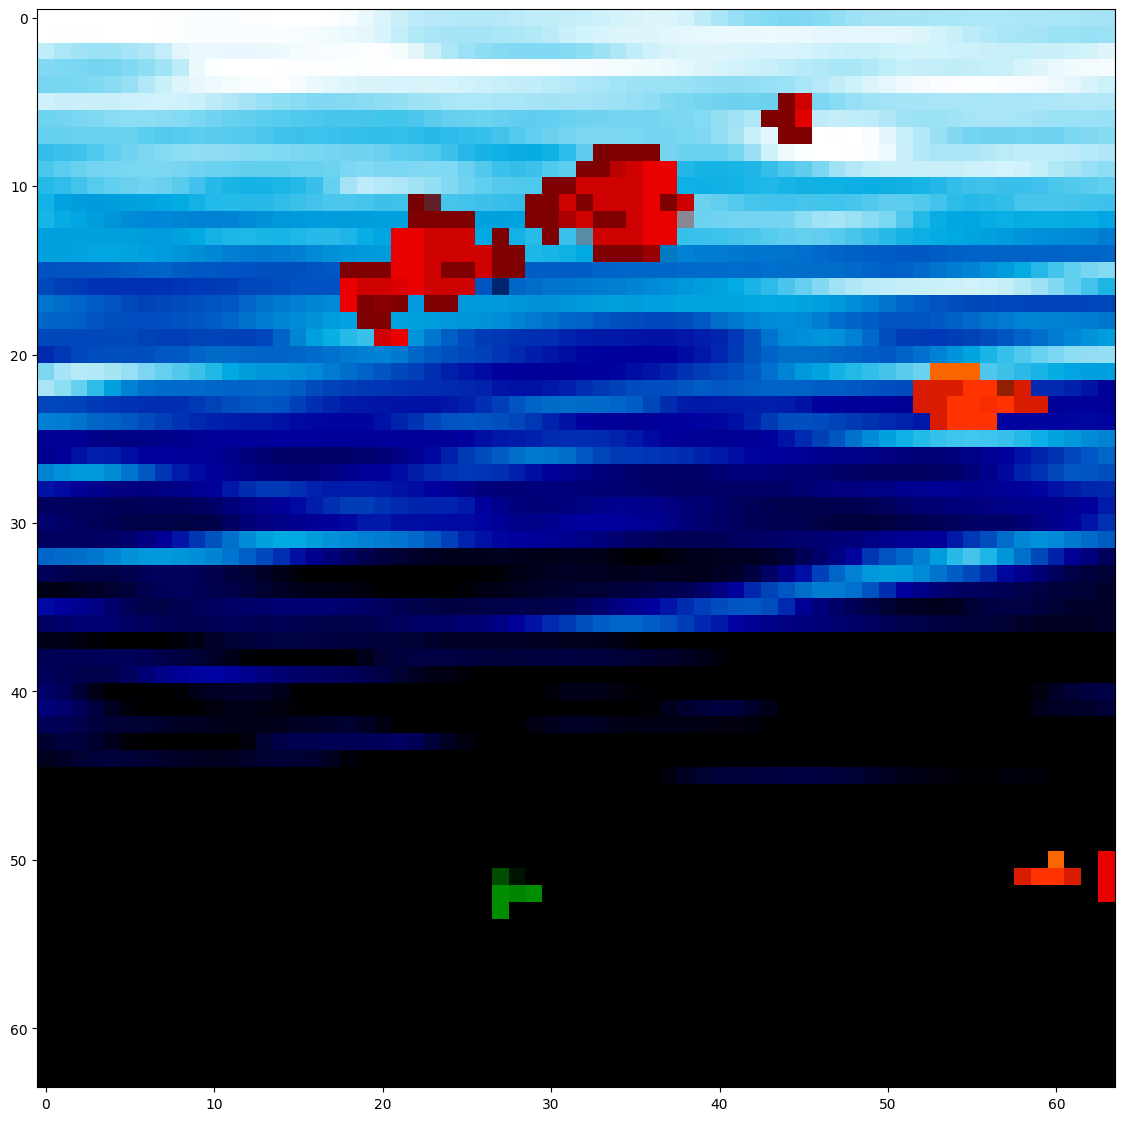

(3, 64, 64)


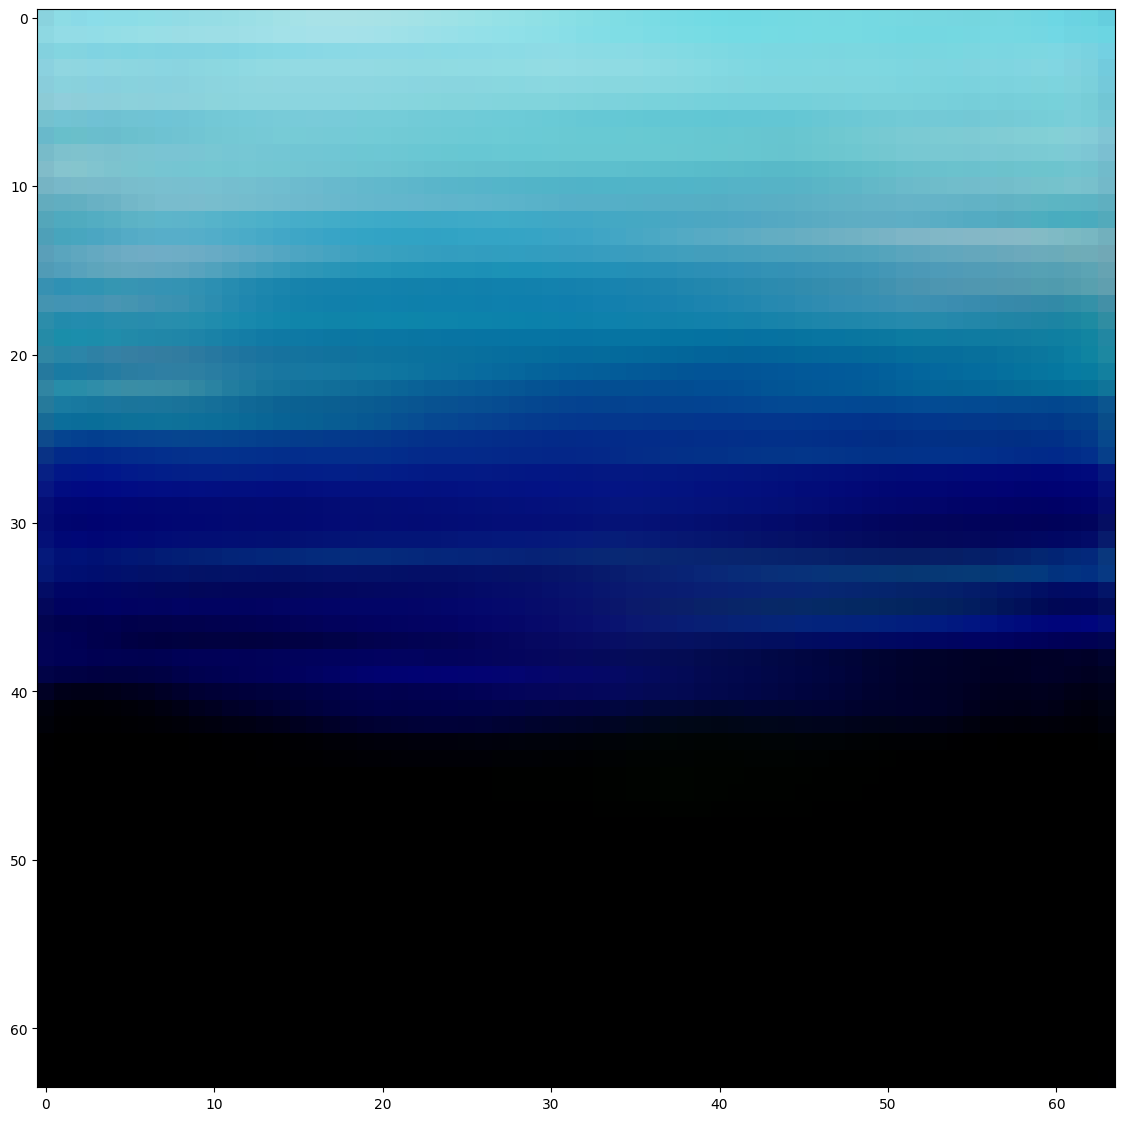

1
loss: 0.261312  [    0/ 1876]
loss: 0.303285  [  187/ 1876]
loss: 0.239393  [  374/ 1876]
loss: 0.305571  [  561/ 1876]
loss: 0.269889  [  748/ 1876]
loss: 0.373304  [  935/ 1876]
loss: 0.297174  [ 1122/ 1876]
loss: 0.316854  [ 1309/ 1876]
loss: 0.227272  [ 1496/ 1876]
loss: 0.269699  [ 1683/ 1876]
loss: 0.311441  [ 1870/ 1876]


(3, 64, 64)


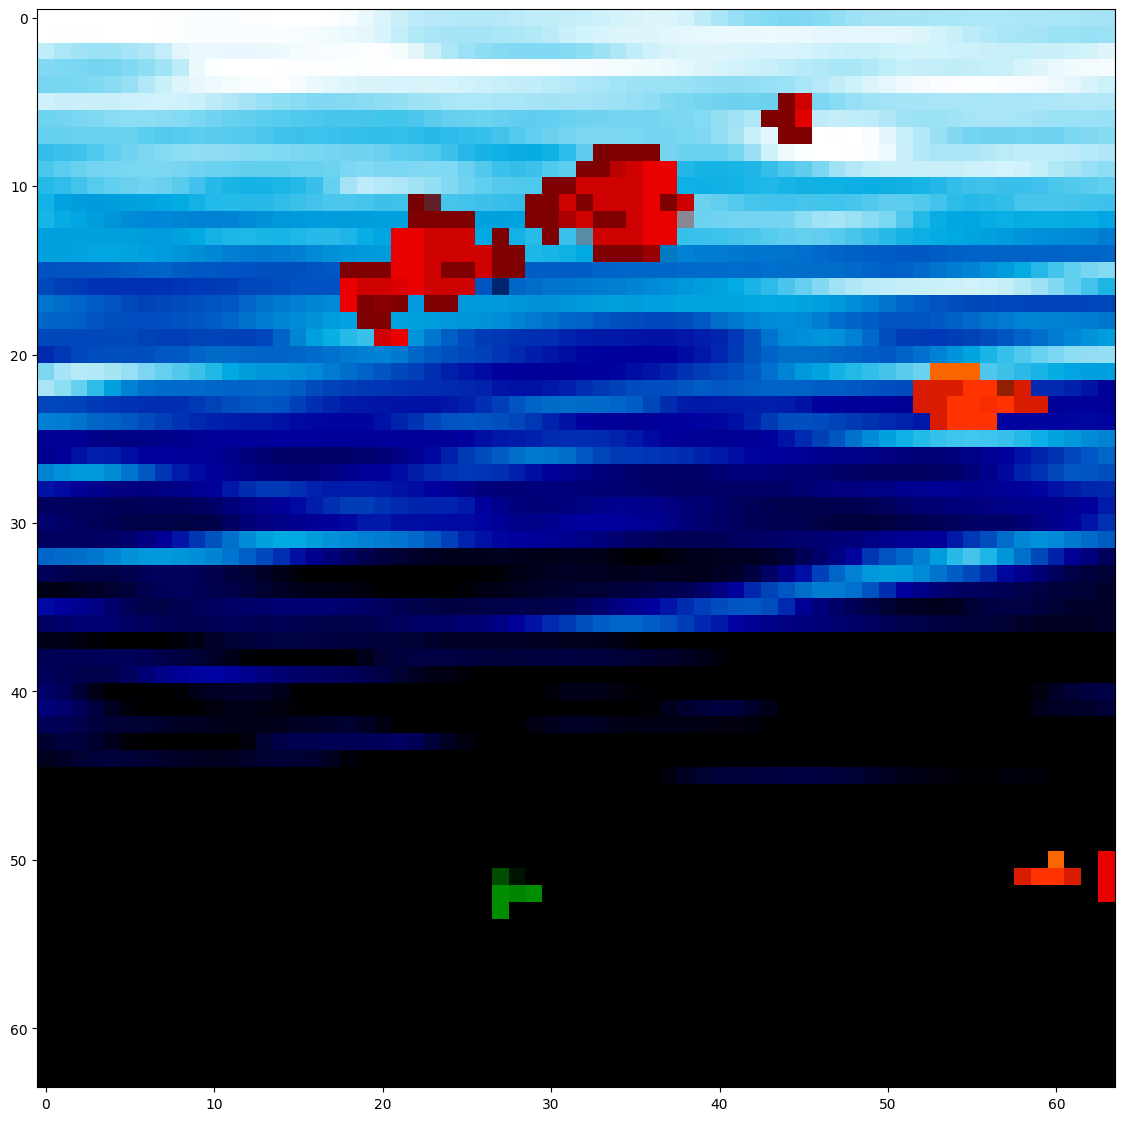

(3, 64, 64)


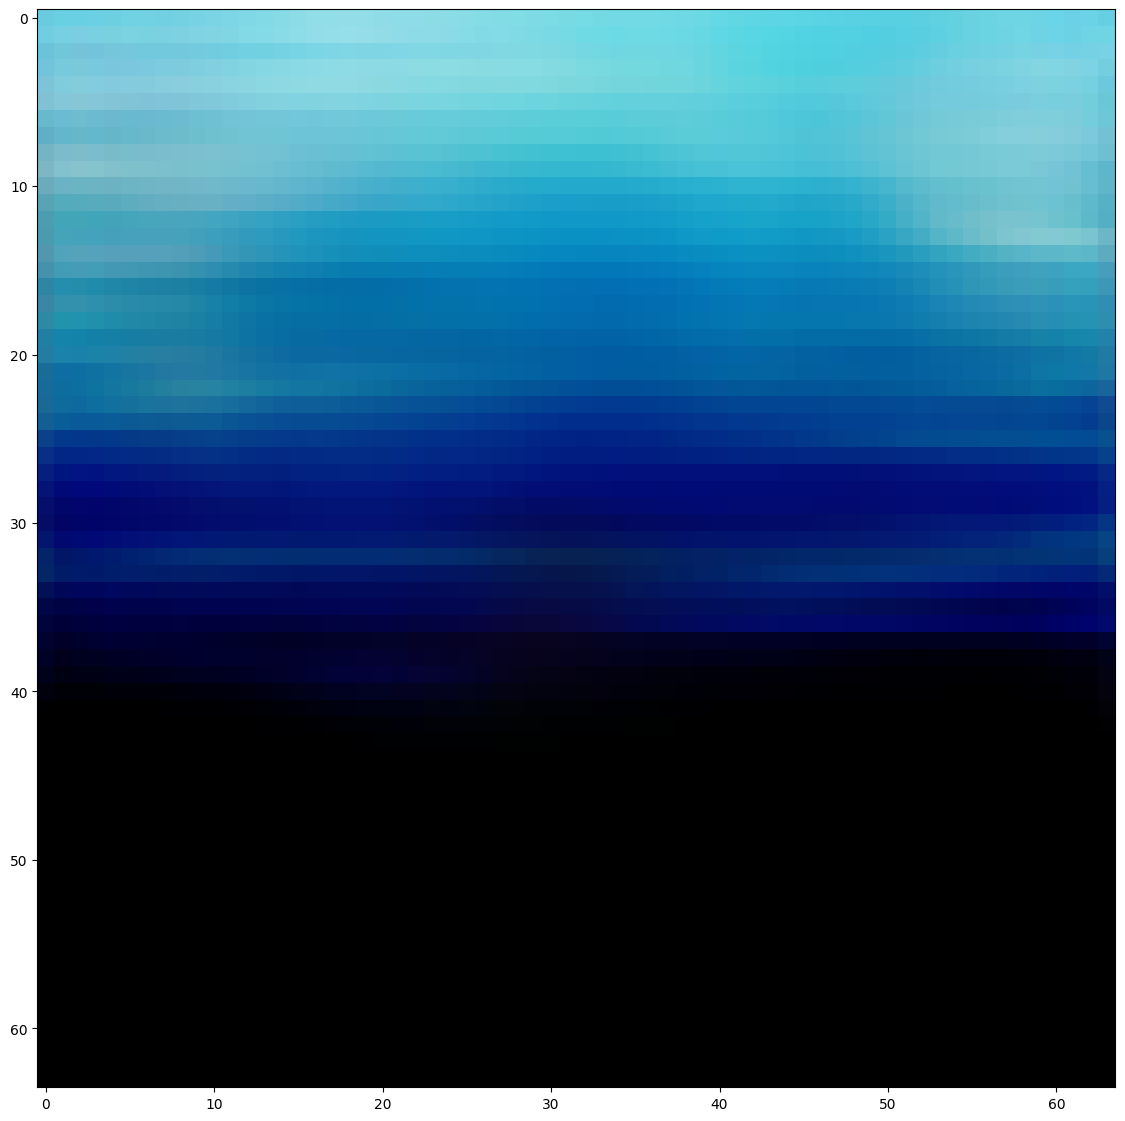

2
loss: 0.313848  [    0/ 1876]
loss: 0.296906  [  187/ 1876]
loss: 0.315004  [  374/ 1876]
loss: 0.299521  [  561/ 1876]
loss: 0.303462  [  748/ 1876]
loss: 0.257920  [  935/ 1876]
loss: 0.319185  [ 1122/ 1876]
loss: 0.301840  [ 1309/ 1876]
loss: 0.316168  [ 1496/ 1876]
loss: 0.238233  [ 1683/ 1876]
loss: 0.259073  [ 1870/ 1876]


(3, 64, 64)


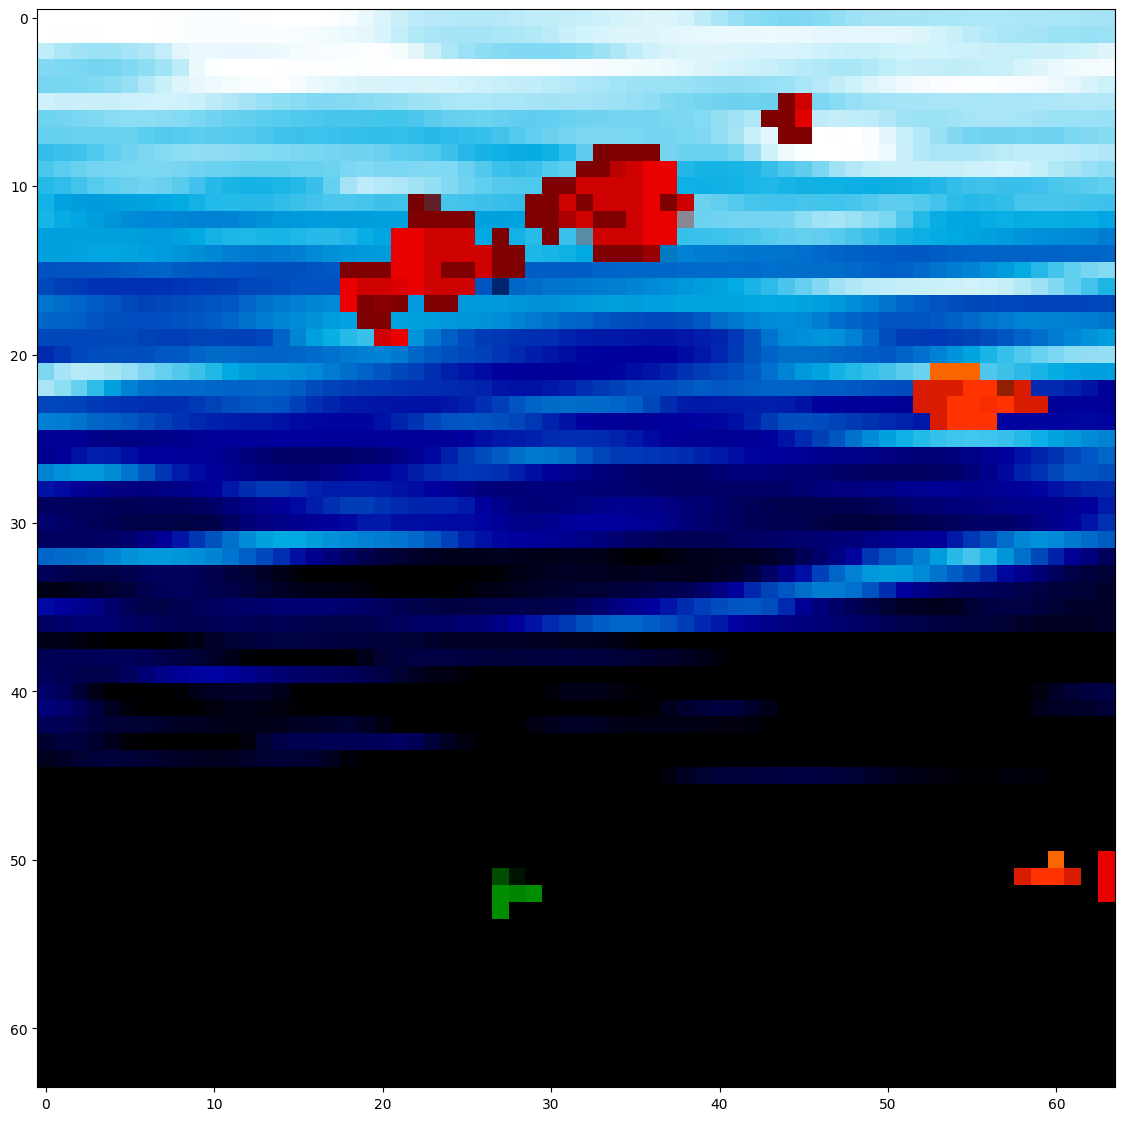

(3, 64, 64)


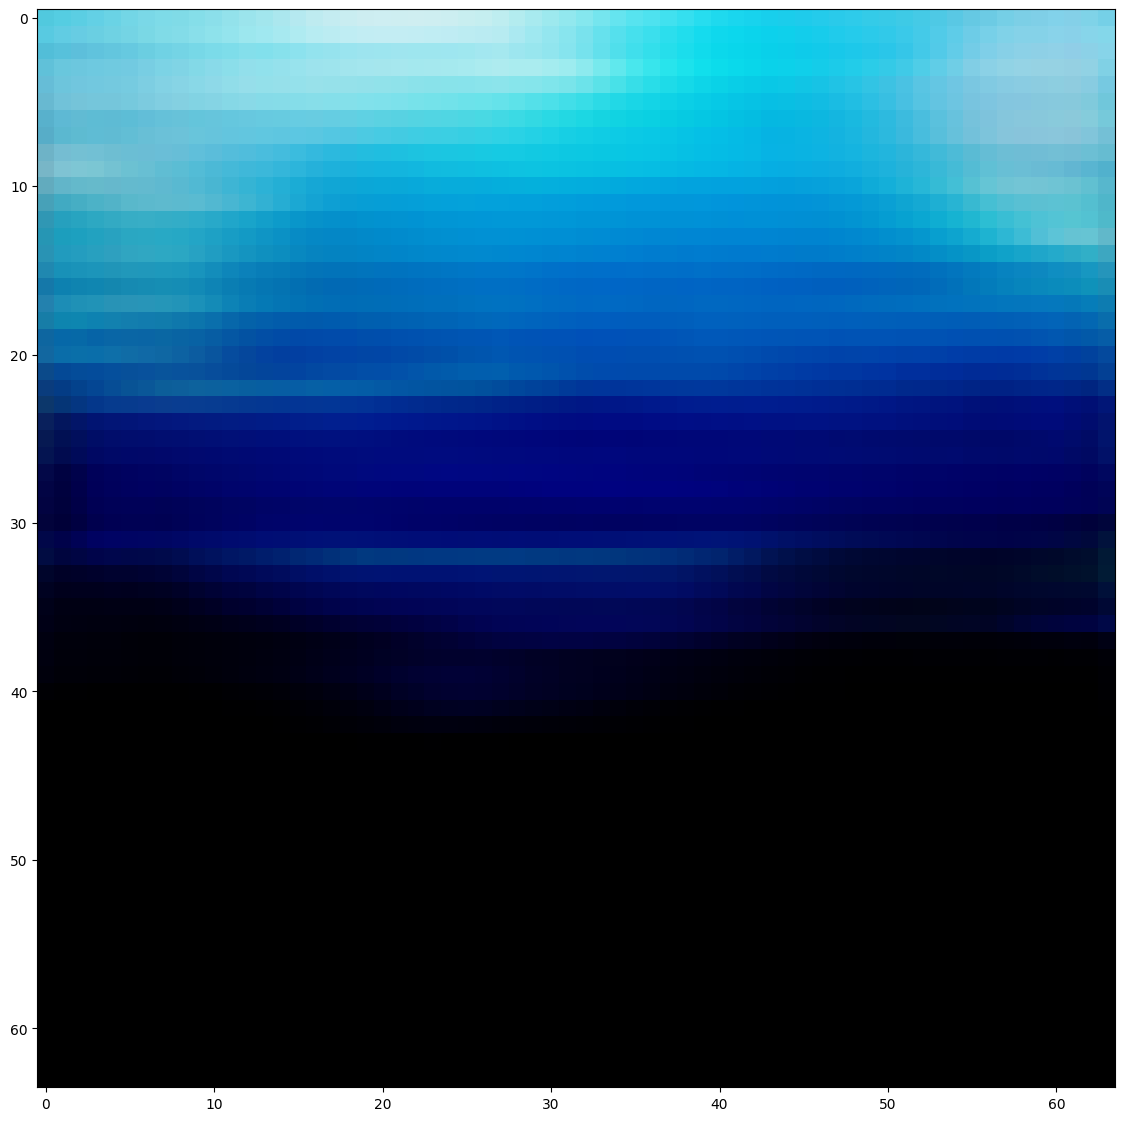

3
loss: 0.283601  [    0/ 1876]
loss: 0.276011  [  187/ 1876]
loss: 0.245706  [  374/ 1876]
loss: 0.292883  [  561/ 1876]
loss: 0.264081  [  748/ 1876]
loss: 0.259026  [  935/ 1876]
loss: 0.271759  [ 1122/ 1876]
loss: 0.312103  [ 1309/ 1876]
loss: 0.244374  [ 1496/ 1876]


In [ ]:
# @title train autoencoder
# print(train_data.data)
# sar=train_data.data
# state, action, reward = zip(*sar)

# loader = DataLoader(state, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4
# optim = torch.optim.AdamW(model.parameters(), 1e-3, (0.9, 0.95)) # 256 lr = 1e-3
# optim = torch.optim.AdamW(model.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-3

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, state in enumerate(dataloader):
        state = state.to(device)
        # sx_ = agent.jepa.enc(state)
        # state_ = agent.conv(sx_)
        state_ = model(state)
        loss = F.mse_loss(state_, state)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        try: wandb.log({"loss": loss.item()})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

epochs=10
num_batches=len(train_loader)
total_steps=int(num_batches*epochs)
max_lr=1e-4
min_lr=1e-7
# min_lr* gamma^total_steps = max_lr
gamma = np.exp(np.log(max_lr/min_lr)/total_steps)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=gamma) # 0.75(20)-0.9(100)

for i in range(epochs):
    print(i)
    # train(train_loader,model,optim)
    train(train_loader,model,optim,scheduler)
    state = buffer[7][80][0]
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    state = transform(state).unsqueeze(0).to(device)[0]
    # print(state.shape)
    sx_ = model.encode(state.unsqueeze(0))
    # print(sx_.shape)
    out= model.decode(sx_.unsqueeze(0)).squeeze(0)
    # print(out.shape)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())


In [50]:
# @title wandb
# https://docs.wandb.ai/quickstart
!pip install wandb
import wandb
wandb.login() # 487a2109e55dce4e13fc70681781de9f50f27be7
run = wandb.init(
    project="conv_ae",
    config={
        "model": "res18",
    })


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole. Use `wandb login --relogin` to force relogin
